In [ ]:
%load_ext lab_black

# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

### 1. Данные (0.5 балла)


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [3]:
CANCER_DATA_PATH = "./hw_knn_data/cancer.csv"

In [4]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.pop("label").map({"M": 1, "B": 0}).values
    x = df.values
    return x, y

In [5]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_cancer.shape, y_cancer.shape

((569, 30), (569,))

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [6]:
def train_test_split(X, y, ratio, random_seed=42):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    mask = np.full(
        X.shape[0],
        False,
    )
    train_size = int(X.shape[0] * ratio)
    mask[:train_size] = True
    np.random.seed(random_seed)
    np.random.shuffle(
        mask,
    )
    return X[mask], y[mask], X[~mask], y[~mask]

In [7]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.7)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((398, 30), (398,), (171, 30), (171,))

### 2. Метрики (0.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [9]:
np.unique(y_cancer)

array([0, 1])

In [10]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    num_classes = 2
    precision = []
    recall = []
    for cs in range(num_classes):
        tp = sum((y_true == cs) & (y_pred == y_true))
        pr = tp / sum(y_pred == cs)
        re = tp / sum(y_true == cs)
        precision.append(pr)
        recall.append(re)
    accuracy = sum(y_true == y_pred) / y_true.shape[0]
    return precision, recall, accuracy

In [11]:
## test
test_y_pred = np.array([1, 0, 1, 0, 0, 0])
test_y_true = np.array([0, 0, 1, 1, 1, 0])
get_precision_recall_accuracy(test_y_pred, test_y_true)

([0.5, 0.5], [0.6666666666666666, 0.3333333333333333], 0.5)

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [12]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)

    def plot(x, ys, ylabel, legend=True):
        plt.figure(figsize=(12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys) - 0.01, np.max(ys) + 0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()

    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [13]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    labels = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0)
                / positive_samples
            )
            fpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0)
                / (len(y_test) - positive_samples)
            )
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
        labels.append(f"k: {k}")
    plt.figure(figsize=(7, 7))
    for tpr, fpr, c, label in zip(curves_tpr, curves_fpr, colors, labels):
        plt.plot(fpr, tpr, color=c, label=label)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.legend()
    plt.show()

## 3. KNN (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [14]:
from sklearn.neighbors import KDTree

In [15]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.num_classes = 2

    def fit(self, X, y):
        self.kd = KDTree(X, leaf_size=self.leaf_size)
        self.y = y

    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        distances, indexes = self.kd.query(
            X,
            self.n_neighbors,
        )
        neighs = self.y[indexes]
        return np.stack(
            [
                (neighs == cl).sum(axis=1) / self.n_neighbors
                for cl in range(self.num_classes)
            ]
        ).T

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на датасете _cancer_

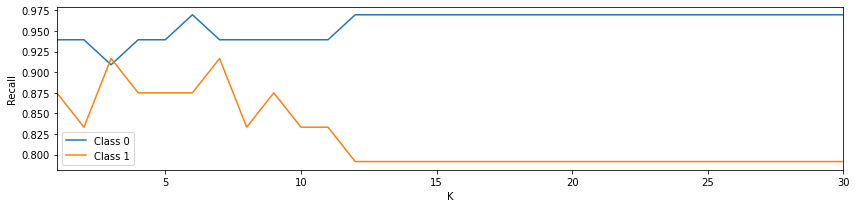

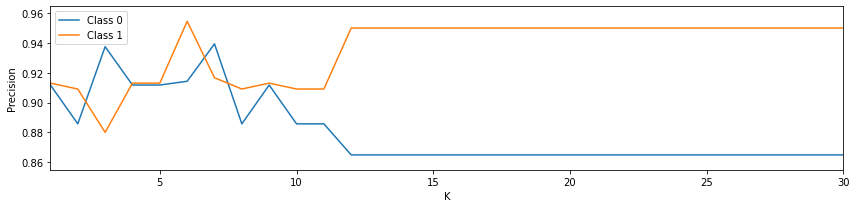

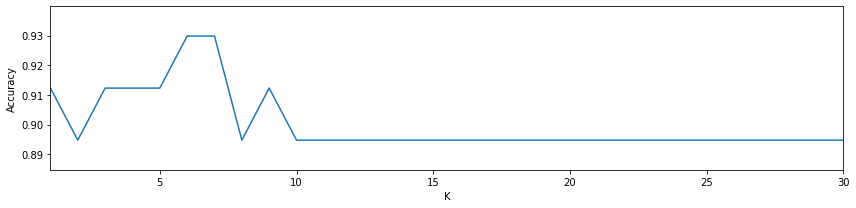

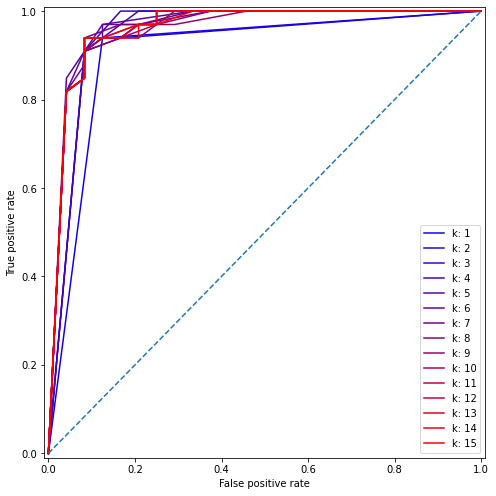

In [16]:
X_train, y_train, X_test, y_test = train_test_split(
    X_cancer, y_cancer, 0.9, random_seed=42
)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=15)



Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

_Ваш ответ_  
Выбрать сложно, тк при разных разбиениях получаются разные. При данном разбиении я бы выбрал k из диапазона [3:8], ориентируясь на Recall и precision. Например k=7

## Clustering (7 баллов)

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [17]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [18]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((max(unique_labels) + 1, 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    for label in unique_labels:
        mask = labels == label
        plt.scatter(
            X[mask, 0], X[mask, 1], color=unique_colors[label], label=f"class: {label}"
        )
    plt.legend()
    plt.show()


def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=flatten_image,
            marker=".",
        )
        axes_pair[1].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=[cluster_colors[c] for c in cluster_labels],
            marker=".",
        )
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

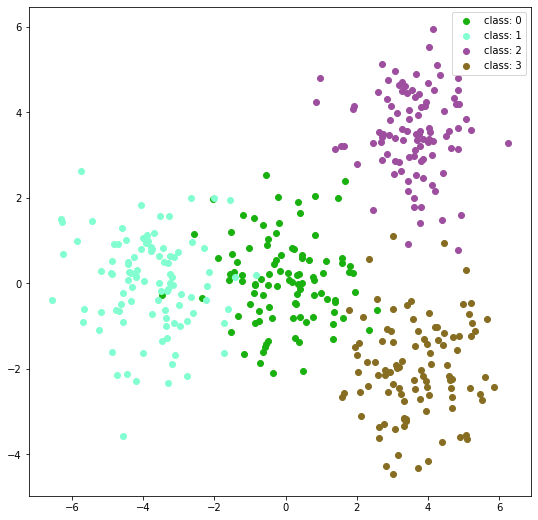

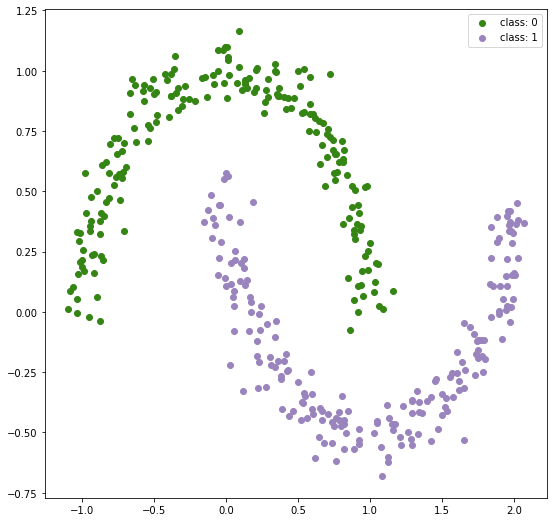

In [19]:
X_1, true_labels = make_blobs(
    400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]]
)
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### 1. K-means (2.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [20]:
# можно было реализовать самому, но это муторно.
from scipy.spatial import distance_matrix


class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, random_seed=42):
        self.init = init
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        np.random.seed(random_seed)

    def fit(self, X, y=None):
        if self.init == "random":
            x_max = X.max(axis=0)
            x_min = X.min(axis=0)
            self.centroids = np.random.sample(size=(self.n_clusters, X.shape[1]))
            self.centroids = self.centroids * (x_max - x_min) + x_min

        elif self.init == "sample":
            centroid_id = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.centroids = X[centroid_id]

        elif self.init == "k-means++":
            centroid_id = np.random.choice(X.shape[0], 1, replace=False)
            self.centroids = X[centroid_id]
            while self.centroids.shape[0] < self.n_clusters:
                distances = distance_matrix(X, self.centroids, p=2)
                weights = (distances ** 2).max(axis=1)
                probas = weights / sum(weights)
                centroid_id = np.random.choice(X.shape[0], 1, replace=False, p=probas)
                centroid = X[centroid_id]
                self.centroids = np.concatenate([self.centroids, centroid])
            print(self.centroids)

        for i in range(self.max_iter):
            old_centroids = self.centroids.copy()
            distances = distance_matrix(X, self.centroids, p=2)
            clusters = distances.argmin(axis=1)
            for cl in range(self.n_clusters):
                mask = clusters == cl
                centroid = X[mask].mean(axis=0)
                self.centroids[cl] = centroid
            dist = np.sqrt(((self.centroids - old_centroids) ** 2).mean())
            if dist < 0.001:
                break
        print(f"num iterations: {i}")

    def predict(self, X):
        print("centroids: ")
        print(self.centroids)
        distances = distance_matrix(X, self.centroids, p=2)
        return distances.argmin(axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

-----------------------------------------------RANDOM-----------------------------------------------
num iterations: 16
centroids: 
[[ 3.68148704 -2.08395208]
 [ 3.55461284  3.45706597]
 [-0.07574086  0.05649877]
 [-3.94824779 -0.00661553]]


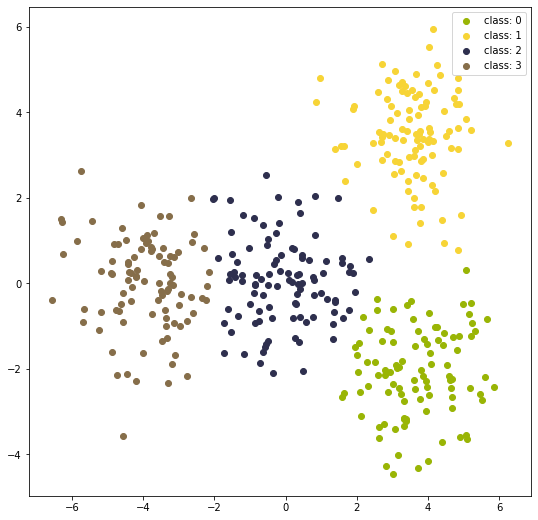

num iterations: 6
centroids: 
[[-0.20212686  0.58768082]
 [ 1.19012039 -0.07899589]]


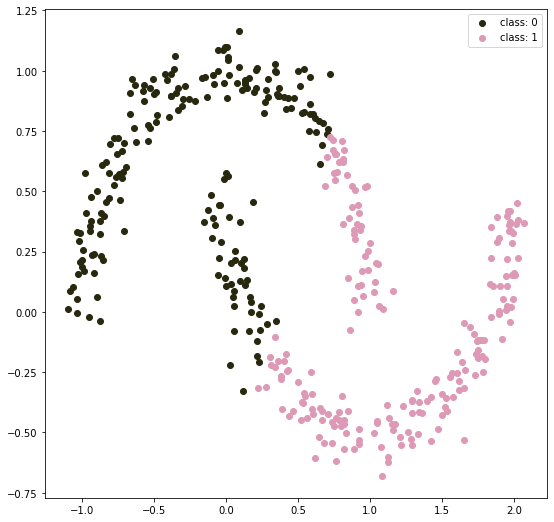

-----------------------------------------------SAMPLE-----------------------------------------------
num iterations: 8
centroids: 
[[-0.03731768  0.01855523]
 [ 3.68148704 -2.08395208]
 [ 3.55461284  3.45706597]
 [-3.90881644  0.0337776 ]]


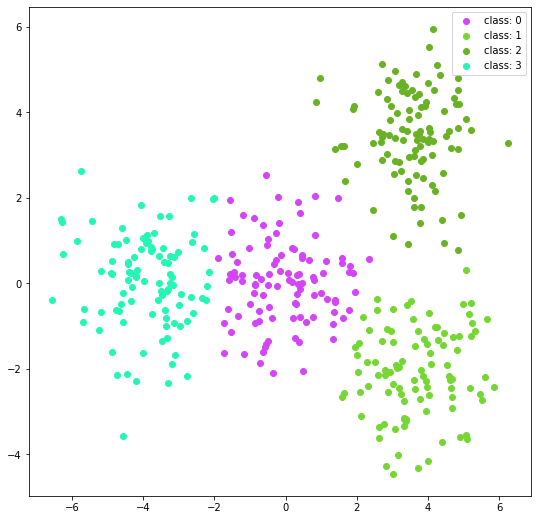

num iterations: 7
centroids: 
[[-0.20212686  0.58768082]
 [ 1.19012039 -0.07899589]]


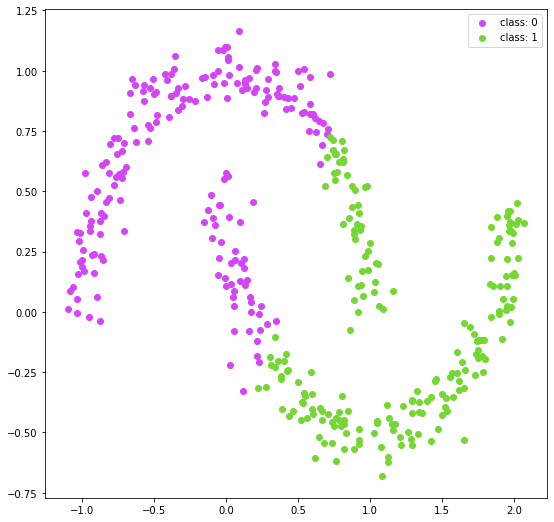

---------------------------------------------K-MEANS++----------------------------------------------
[[ 3.12979058 -1.9766924 ]
 [ 2.74036062  3.49664913]
 [-0.53974536 -1.41996163]
 [-2.22762201 -0.39837339]]
num iterations: 4
centroids: 
[[ 3.68148704 -2.08395208]
 [ 3.55461284  3.45706597]
 [-0.03731768  0.01855523]
 [-3.90881644  0.0337776 ]]


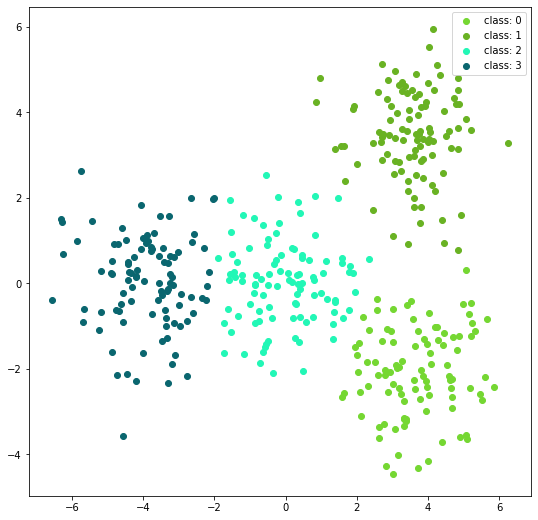

[[-0.74474878  0.57122522]
 [ 1.83672023  0.11396292]]
num iterations: 4
centroids: 
[[-0.1953399   0.58383604]
 [ 1.19725417 -0.08182296]]


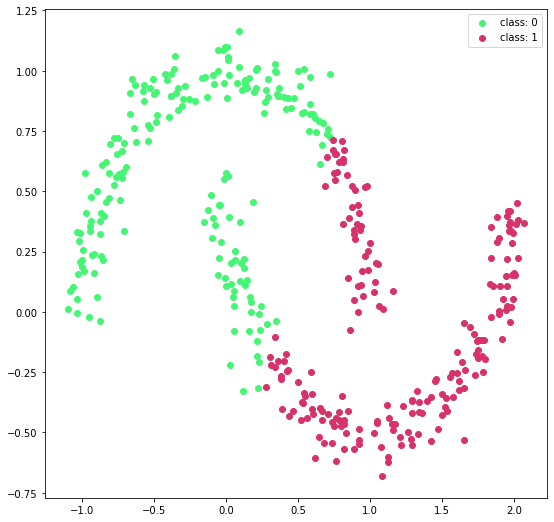

In [21]:
for init in ["random", "sample", "k-means++"]:
    print(init.upper().center(100, "-"))
    kmeans = KMeans(n_clusters=4, init=init)
    kmeans.fit(X_1)
    labels = kmeans.predict(X_1)
    visualize_clasters(X_1, labels)

    kmeans = KMeans(n_clusters=2, init=init)
    kmeans.fit(X_2)
    labels = kmeans.predict(X_2)
    visualize_clasters(X_2, labels)

С евклидовой метрикой хорошо кластеризуются данные имеющие "шарообразные" кластеры, плохо кластеры других типов. На этих данные разница в инициализации только в скорости сходимости(графики не строил, но интуитивно понятно)

### 2. DBScan (3.5 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [22]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric

    def fit_predict(self, X, y=None):
        kd = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        y = np.full(X.shape[0], 0)
        cs = 0
        iteration = -1
        while True:
            iteration += 1
            # initializing
            for index in np.random.choice(
                np.where(y == 0)[0], (y == 0).sum(), replace=False
            ):
                if (
                    len(kd.query_radius(X[index : index + 1], r=self.eps)[0])
                    > self.min_samples
                ):  # one more because index in list
                    init_index = index
                    break  # not core point
            else:
                break  # no core points for initializing, breaking While loop
            cs += 1
            y[init_index] = cs
            any_new = True
            outlier = False
            while any_new:
                any_new = False
                for ind in np.where(y == cs)[0]:
                    neighbors = kd.query_radius(X[ind : ind + 1], r=self.eps)[0]
                    if (len(neighbors) > self.min_samples) & any(
                        y[neighbors] == 0
                    ):  # one more because ind in list
                        y[neighbors] = cs
                        any_new = True
        print(f"classes: {iteration}")
        return y

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

class: 0 - не классицицироанные точки, параметры подбирал под метрику евклида

---------------------------------------------EUCLIDEAN----------------------------------------------
classes: 4


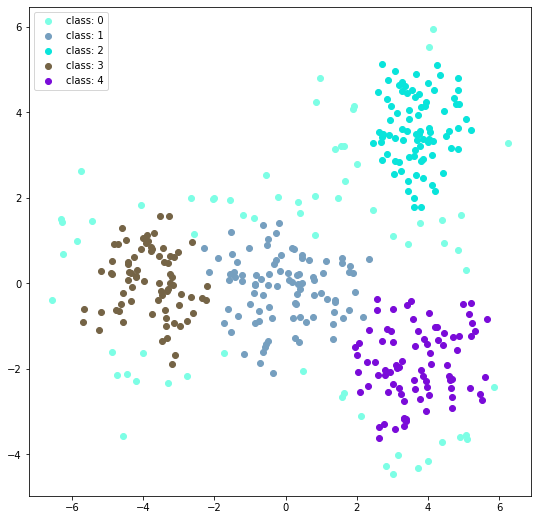

classes: 2


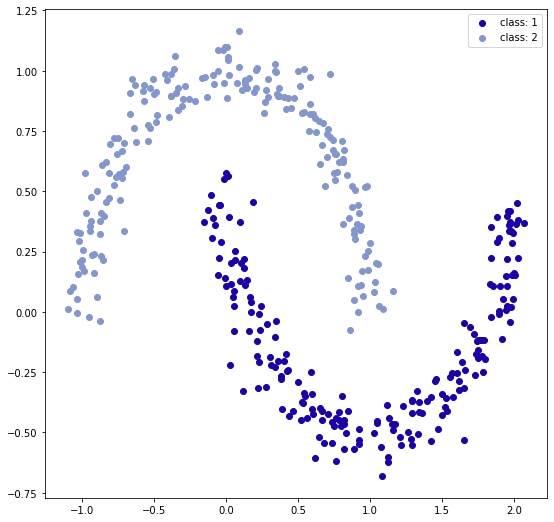

---------------------------------------------CHEBYSHEV----------------------------------------------
classes: 2


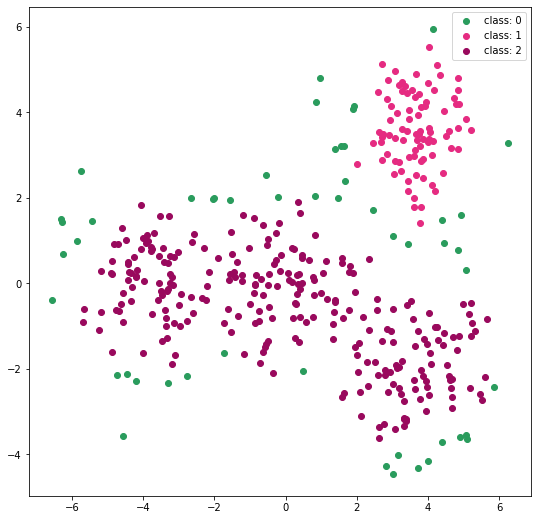

classes: 2


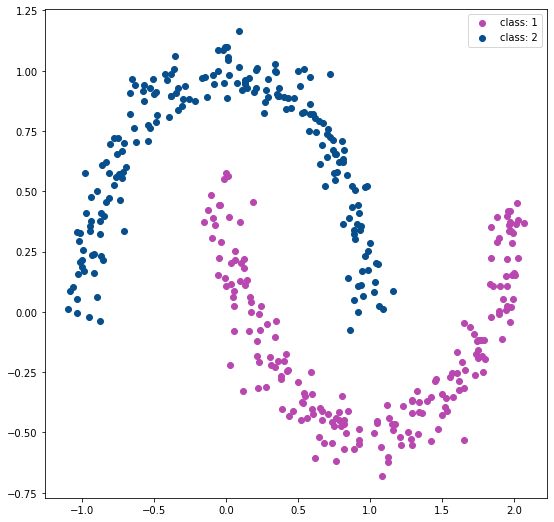

---------------------------------------------MANHATTAN----------------------------------------------
classes: 8


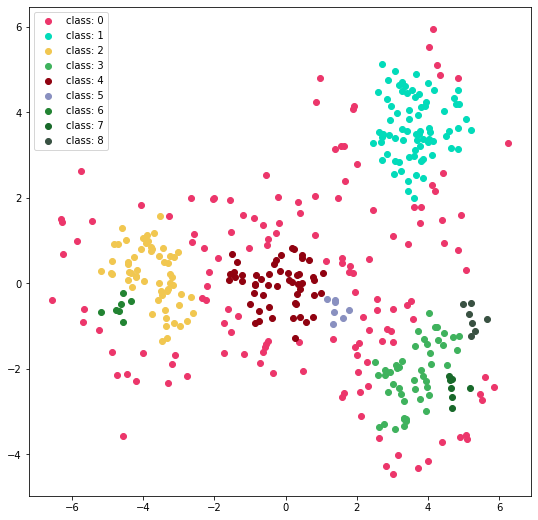

classes: 2


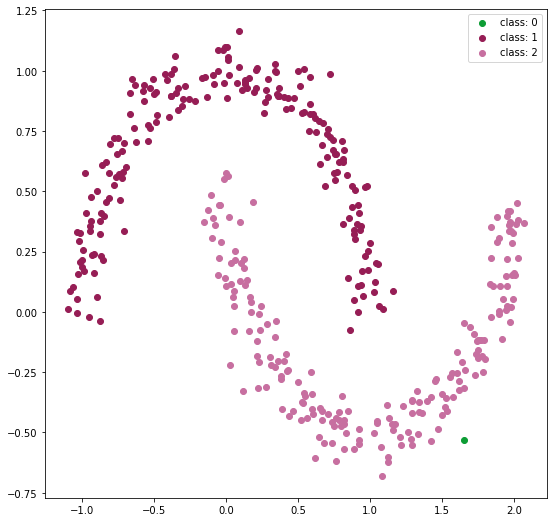

In [23]:
for metrics in ["euclidean", "chebyshev", "manhattan"]:
    print(metrics.upper().center(100, "-"))
    dbscan = DBScan(min_samples=6, eps=0.6, metric=metrics)
    labels = dbscan.fit_predict(X_1)
    visualize_clasters(X_1, labels)

    dbscan = DBScan(eps=0.2, metric=metrics)
    labels = dbscan.fit_predict(X_2)
    visualize_clasters(X_2, labels)

### 3. Оценка качества моделей (1 балл)
Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

_Ваш ответ_

Если смотреть на графики - лучше с X_1 справляется Kmeans, потому что кластеры компактные(в метрике), но тк есть неравномерность плотности DBScan оставляет много некластеризованных и добовляет еще один класс. Возможно, можно более аккуратно подобрать парамеры DBScan.  
С X_2 лучше справляется DBScan тк кластеры "компактные" в контексте метрики расстояния, зато плотность в них равномерная и расстояния между объектами разных кластеров достаточно большое.  

In [24]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [25]:
scores = []
for cluster_metric in [davies_bouldin_score, silhouette_score]:
    for clust in [
        KMeans(n_clusters=4, init="k-means++"),
        DBScan(min_samples=6, eps=0.6, metric="euclidean"),
    ]:
        labels = clust.fit_predict(X_1)
        score = cluster_metric(X_1, labels)
        scores.append(
            {
                "metric": cluster_metric.__name__,
                "cluster": clust.__class__.__name__,
                "score": score,
                "dataset": "X_1",
            }
        )

for cluster_metric in [davies_bouldin_score, silhouette_score]:
    for clust in [
        KMeans(n_clusters=2, init="k-means++"),
        DBScan(eps=0.2, metric="euclidean"),
    ]:
        labels = clust.fit_predict(X_2)
        score = cluster_metric(X_2, labels)
        scores.append(
            {
                "metric": cluster_metric.__name__,
                "cluster": clust.__class__.__name__,
                "score": score,
                "dataset": "X_2",
            }
        )

[[ 3.12979058 -1.9766924 ]
 [ 2.74036062  3.49664913]
 [-0.53974536 -1.41996163]
 [-2.22762201 -0.39837339]]
num iterations: 4
centroids: 
[[ 3.68148704 -2.08395208]
 [ 3.55461284  3.45706597]
 [-0.03731768  0.01855523]
 [-3.90881644  0.0337776 ]]
classes: 4
[[ 3.12979058 -1.9766924 ]
 [ 2.74036062  3.49664913]
 [-0.53974536 -1.41996163]
 [-2.22762201 -0.39837339]]
num iterations: 4
centroids: 
[[ 3.68148704 -2.08395208]
 [ 3.55461284  3.45706597]
 [-0.03731768  0.01855523]
 [-3.90881644  0.0337776 ]]
classes: 4
[[-0.74474878  0.57122522]
 [ 1.83672023  0.11396292]]
num iterations: 4
centroids: 
[[-0.1953399   0.58383604]
 [ 1.19725417 -0.08182296]]
classes: 2
[[-0.74474878  0.57122522]
 [ 1.83672023  0.11396292]]
num iterations: 4
centroids: 
[[-0.1953399   0.58383604]
 [ 1.19725417 -0.08182296]]
classes: 2


In [26]:
pd.DataFrame(scores)

,metric,cluster,score,dataset
0,davies_bouldin_score,KMeans,0.613800,X_1
1,davies_bouldin_score,DBScan,4.206020,X_1
2,silhouette_score,KMeans,0.547161,X_1
3,silhouette_score,DBScan,0.410558,X_1
4,davies_bouldin_score,KMeans,0.782626,X_2
5,davies_bouldin_score,DBScan,1.164504,X_2
6,silhouette_score,KMeans,0.486398,X_2
7,silhouette_score,DBScan,0.328251,X_2


Сложно сравниать, тк DBScan оставляет некластеризованные объекты. Если смотреть на davies_bouldin_score(меньше - лучше), то KMEANS лучше кластеризует оба датасета, но это не так(это получается из определения метрики, она хорошо подходит ддял компактных кластеров)  

Если смотреть на silhouette_score(больше - лучше), то опять KMEANS лучше кластеризует, но это возможно из-за того, что DBSCAN сотавляет некластеризованные

Непонятно, можно ли сравнивать эти скоры, еси чсть обектов одной модели не кластеризуются